# prep

In [138]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [140]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_LM = meta.copy()
meta_LM.tail()

LM    22
Name: area, dtype: int64 22


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
17,1373,230302,LM,200.000,3,1.000,NaN,grating,6s,NaN,NaN
18,1373,230302,LM,150.000,4,1.000,NaN,grating,6s,NaN,NaN
19,1381,230307,LM,200.000,2,1.000,NaN,grating,6s,NaN,NaN
20,1381,230307,LM,200.000,3,1.000,NaN,grating,6s,NaN,NaN
21,1381,230307,LM,150.000,4,1.000,NaN,grating,6s,NaN,NaN


In [141]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_V1 = meta.copy()
meta_V1

V1    6
Name: area, dtype: int64 6


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200720,V1,200.000,3,NaN,True,grating,6s,1.000,NaN
1,1324,200728,V1,200.000,3,NaN,True,grating,6s,NaN,NaN
2,1322,200803,V1,200.000,2,NaN,True,grating,6s,NaN,NaN
3,1328,201015,V1,200.000,4,NaN,True,grating,6s,1.000,NaN
4,1329,201209,V1,200.000,2,NaN,True,grating,6s,NaN,NaN
5,1337,210120,V1,150.000,3,1.000,NaN,grating,6s,NaN,NaN


# df tidy for 1 set
grat 8ori 3isi

In [95]:
iset = 20

mouse = meta.loc[iset, 'mouse'].astype(str)
date = meta.loc[iset, 'date'].astype(str)
area = meta.loc[iset, 'area']
sess = '00' + meta.loc[iset, 'num'].astype(str)
print(mouse, date, area, sess)

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
for dirname in os.listdir(dir_data):
    if mouse in dirname and date in dirname and area in dirname and sess in dirname:
        dir_data = dir_data + dirname
        break

stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

1381 230307 LM 002
ncell: 87, nstim: 1, ntrial: 500, nframe: 207


(dict_keys(['stim_ori', 'isi_nframe', 'adapter_contrast']), (87, 500, 207))

trace_cell_avg: (207,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (207,)


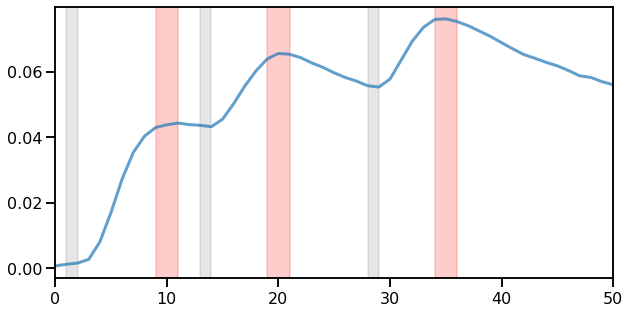

In [ ]:
## find resp window. TODO: auto detect
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

base1_frame = 1
resp_ad_frame = 9
base2_frame = 13
resp_tg250_frame = 19
base3_frame = 28
resp_tg750_frame = 34

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell, alpha=0.7, linewidth=3)
ax.axvspan(base1_frame, base1_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_ad_frame, resp_ad_frame+2, alpha=0.2, color='red')
ax.axvspan(base2_frame, base2_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg250_frame, resp_tg250_frame+2, alpha=0.2, color='red')
ax.axvspan(base3_frame, base3_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg750_frame, resp_tg750_frame+2, alpha=0.2, color='red')
plt.xlim(0, 50);

In [ ]:
## get resp_ad and resp_tg [cell x trial]

base1 = trace_by_trial[:, :, base1_frame : base1_frame+1+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:, :, resp_ad_frame : resp_ad_frame+2+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:, :, base2_frame : base2_frame+1+1].mean(axis=2)
resp_tg250 = trace_by_trial[:, :, resp_tg250_frame : resp_tg250_frame+2+1].mean(axis=2)
resp_tg250 = resp_tg250 - base2

base3 = trace_by_trial[:, :, base3_frame : base3_frame+1+1].mean(axis=2)
resp_tg750 = trace_by_trial[:, :, resp_tg750_frame : resp_tg750_frame+2+1].mean(axis=2)
resp_tg750 = resp_tg750 - base3

resp_ad.shape, resp_tg250.shape, resp_tg750.shape

((87, 500), (87, 500), (87, 500))

In [ ]:
trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]

## stitch resp_tg250 and resp_tg750 together, based on trial_isi_nframe
ntrial = resp_ad.shape[1]
resp_tg = np.zeros_like(resp_ad)
for itrial in range(ntrial):
    resp_tg[:, itrial] = resp_tg250[:, itrial] if trial_isi_nframe[itrial] < 10 else resp_tg750[:, itrial]
# print(np.unique(trial_isi_nframe)) # 10 > 8 frame == 250 ms

R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
R2_dfof = resp_tg.flatten()
dfof = np.hstack((R1_dfof, R2_dfof))

In [ ]:
ncell = resp_ad.shape[0]
ntrial = resp_ad.shape[1]
cell_id = np.repeat(np.arange(ncell), ntrial)
cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

trial_id = np.tile(np.arange(ntrial), ncell)
trial_id = np.hstack((trial_id, trial_id))

len_df = ncell * ntrial * 2 # 2 for (R1, R2)
resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

cell_id.shape, trial_id.shape, dfof.shape, len(resp_id)

((87000,), (87000,), (87000,), 87000)

In [ ]:
## map stim2 orientation to int
trial_stim_orien = [item[0] for item in stim_id['stim_ori']]
print(np.sort(np.unique(trial_stim_orien)))

trial_stim_orien_dict = {}
for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
    trial_stim_orien_dict[item] = i
trial_stim_orien_dict

trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]


In [ ]:
trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
trial_isi_nframe = trial_isi_nframe[:ntrial]
trial_adapter_contrast = trial_adapter_contrast[:ntrial]

stim_id_col = np.tile(trial_stim_orien_int, ncell)
isi_col = np.tile(trial_isi_nframe, ncell)
ad_con_col = np.tile(trial_adapter_contrast, ncell)
stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
adapter_id_col = np.zeros_like(stim_id_col)
isi_col = np.hstack((isi_col, isi_col))
ad_con_col = np.hstack((ad_con_col, ad_con_col))

stim_id_col.shape, isi_col.shape, ad_con_col.shape, adapter_id_col.shape

((87000,), (87000,), (87000,), (87000,))

In [ ]:
df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                        'isi': isi_col, 'stim1_contrast': ad_con_col, 
                        'stim2_id': stim_id_col, 'stim1_id': adapter_id_col,})
df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id
0,0.399759,0,0,R1,8,1,3,0
1,0.027992,0,3,R1,23,1,6,0
2,0.054808,0,6,R1,8,1,3,0
3,0.029828,0,8,R1,23,1,5,0
4,-0.012044,0,11,R1,23,1,2,0
...,...,...,...,...,...,...,...,...
74293,0.011308,86,495,R2,23,1,2,0
74294,-0.008860,86,496,R2,23,1,7,0
74295,-0.039800,86,497,R2,8,1,2,0
74296,-0.011214,86,498,R2,8,1,5,0


In [ ]:
## vis cell filter & img driven cell-stim filter

df_tidy['filter_cell'] = np.nan
df_tidy['filter_cell_stim'] = np.nan

with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
    filter_file = pickle.load(f)
filter_cell_stim = filter_file['img_driven']
filter_cell = filter_file['vis_driven']

print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
for icell in np.arange(filter_cell_stim.shape[0]):
    df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
    for istim in np.arange(filter_cell_stim.shape[1]):
        df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
        
df_tidy
# df_tidy.filter_cell.value_counts(), df_tidy.filter_cell_stim.value_counts()

ncell = 87, nstim = 8


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,filter_cell,filter_cell_stim
0,0.399759,0,0,R1,8,1,3,0,False,False
1,0.027992,0,3,R1,23,1,6,0,False,False
2,0.054808,0,6,R1,8,1,3,0,False,False
3,0.029828,0,8,R1,23,1,5,0,False,False
4,-0.012044,0,11,R1,23,1,2,0,False,False
...,...,...,...,...,...,...,...,...,...,...
74293,0.011308,86,495,R2,23,1,2,0,True,False
74294,-0.008860,86,496,R2,23,1,7,0,True,False
74295,-0.039800,86,497,R2,8,1,2,0,True,False
74296,-0.011214,86,498,R2,8,1,5,0,True,False


# df tidy for n set

## find resp window

In [147]:
trace_avg_cell_set = []
# meta = meta_V1.copy()
meta = meta_LM.copy()
nset = meta.shape[0]

for iset in range(nset):

    mouse = meta.loc[iset, 'mouse'].astype(str)
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(dir_data):
        if mouse in dirname and date in dirname and area in dirname and sess in dirname:
            dir_data = os.path.join(dir_data, dirname)
            break

    stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
    stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

    trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)
    trace_avg_cell_set.append(trace_avg_cell)

trace_avg_cell_set = np.array(trace_avg_cell_set)
clear_output()

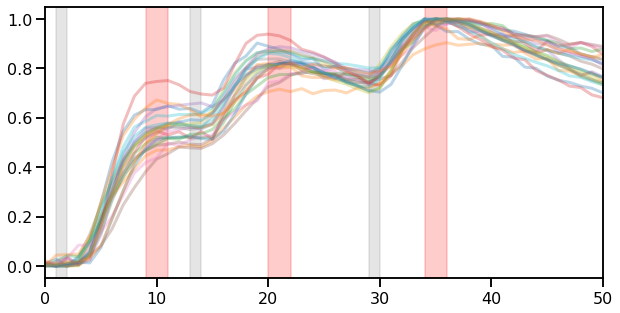

In [149]:
base1_frame = 1
resp_ad_frame = 9
base2_frame = 13
resp_tg250_frame = 20
base3_frame = 29
resp_tg750_frame = 34

fig, ax = plt.subplots(figsize=(10, 5))
for iset in range(nset):
    trace_now = trace_avg_cell_set[iset]
    # max min normalization
    trace_now = (trace_now - np.min(trace_now) ) / (np.max(trace_now) - np.min(trace_now))
    plt.plot(trace_now, alpha=0.3, linewidth=3)

ax.axvspan(base1_frame, base1_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_ad_frame, resp_ad_frame+2, alpha=0.2, color='red')
ax.axvspan(base2_frame, base2_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg250_frame, resp_tg250_frame+2, alpha=0.2, color='red')
ax.axvspan(base3_frame, base3_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg750_frame, resp_tg750_frame+2, alpha=0.2, color='red')

plt.xlim(0, 50);

## batch write df_tidy

In [156]:
meta = pd.concat([meta_V1, meta_LM], axis=0).reset_index(drop=True)
nset = len(meta)

for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')

    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
    # stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

    ## slice by resp window, determined by section above
    if area == 'V1':
        base1_frame = 1
        resp_ad_frame = 9
        base2_frame = 13
        resp_tg250_frame = 19
        base3_frame = 29
        resp_tg750_frame = 34
    elif area == 'LM':
        base1_frame = 1
        resp_ad_frame = 9
        base2_frame = 13
        resp_tg250_frame = 20
        base3_frame = 29
        resp_tg750_frame = 34

    ## get resp_ad and resp_tg [cell x trial]
    base1 = trace_by_trial[:, :, base1_frame : base1_frame+1+1].mean(axis=2) # avg over time window frames. one more plus 1 is to include the last frame
    resp_ad = trace_by_trial[:, :, resp_ad_frame : resp_ad_frame+2+1].mean(axis=2)
    resp_ad = resp_ad - base1

    base2 = trace_by_trial[:, :, base2_frame : base2_frame+1+1].mean(axis=2)
    resp_tg250 = trace_by_trial[:, :, resp_tg250_frame : resp_tg250_frame+2+1].mean(axis=2)
    resp_tg250 = resp_tg250 - base2

    base3 = trace_by_trial[:, :, base3_frame : base3_frame+1+1].mean(axis=2)
    resp_tg750 = trace_by_trial[:, :, resp_tg750_frame : resp_tg750_frame+2+1].mean(axis=2)
    resp_tg750 = resp_tg750 - base3

    ## construct dfof
    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    ntrial = resp_ad.shape[1]
    resp_tg = np.zeros_like(resp_ad)
    for itrial in range(ntrial): # stitch resp_tg250 and resp_tg750 together, based on trial_isi_nframe
        resp_tg[:, itrial] = resp_tg250[:, itrial] if trial_isi_nframe[itrial] < 10 else resp_tg750[:, itrial]
    # print(np.unique(trial_isi_nframe)) # NOTE 10 > 8 frame == 250 ms

    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof))

    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial)
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

    trial_id = np.tile(np.arange(ntrial), ncell)
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
    trial_stim_orien_dict = {} ## map stim2 orientation to int
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]

    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    adapter_id_col = np.zeros_like(stim_id_col) # adapter (stim1) is always 0 deg / vertical gratings
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col, 'stim1_id': adapter_id_col,})
    df_tidy['area'] = area
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    df_tidy['filter_cell_well_fit'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
    well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']]) # bool, ncell x 1

    # print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
    for icell in np.arange(filter_cell_stim.shape[0]):
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell][0] # filter_cell_vis is a list of list
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()

    ## cell tuning in 3 possible ISI
    fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat'))
    ori_pref_isi3 = fit_tuning['ori_pref'] # ncell x 3isi, [noad vs ad750 vs ad250]
    
    df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms
    df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)

    use_irun = [0, 1] # out of 1000 bootstrap runs, use the first 2 runs
    ori_pref_noad1 = well_fit['ori_pref_runs'][:, use_irun[0]]
    ori_pref_noad2 = well_fit['ori_pref_runs'][:, use_irun[1]]

    ncell = df_tidy.cell_id.unique().shape[0]
    for icell in np.arange(ncell):
        # df_tidy.loc[(df_tidy.cell_id == icell) & (df_tidy.isi == 6000), 'ori_pref'] = ori_pref_isi3[icell, 0] # ori_pref_isi3 is ncell x 3isi, [noad vs ad750 vs ad250]
        # df_tidy.loc[(df_tidy.cell_id == icell) & (df_tidy.isi == 750), 'ori_pref'] = ori_pref_isi3[icell, 1]
        # df_tidy.loc[(df_tidy.cell_id == icell) & (df_tidy.isi == 250), 'ori_pref'] = ori_pref_isi3[icell, 2]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_isi3[icell, 0] # ori_pref_isi3 is ncell x 3isi, [noad vs ad750 vs ad250]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_isi3[icell, 1]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_isi3[icell, 2]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_noad1[icell]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_noad2[icell]
    
    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_split_noad.csv'), index=False)

clear_output()

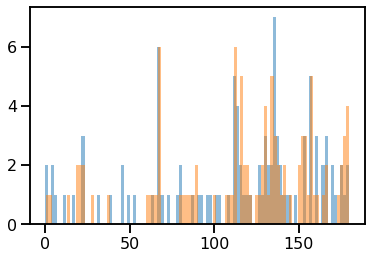

In [134]:
# well_fit = sio.loadmat(os.path.join(dir_data, dir_identifier, 'fit_bootstrap_90perc.mat'))
# well_fit['ori_pref_runs'].shape

# use_irun = [0, 1]
# ori_pref_noad1 = well_fit['ori_pref_runs'][:, use_irun[0]]
# ori_pref_noad2 = well_fit['ori_pref_runs'][:, use_irun[1]]

# plt.hist(ori_pref_noad1, bins=100, alpha=0.5);
# plt.hist(ori_pref_noad2, bins=100, alpha=0.5);

# batch load df_tidy

In [157]:
meta = pd.concat([meta_V1, meta_LM], axis=0).reset_index(drop=True)
meta.sample(5, random_state=0)

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
2,1322,200803,V1,200.000,2,NaN,True,grating,6s,NaN,NaN
22,1380,230221,LM,150.000,3,1.000,NaN,grating,6s,NaN,TC not pretty
14,1337,210127,LM,150.000,3,1.000,NaN,grating,6s,NaN,NaN
17,1350,211020,LM,200.000,2,1.000,NaN,grating,6s,NaN,NaN
5,1337,210120,V1,150.000,3,1.000,NaN,grating,6s,NaN,NaN


In [192]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, 'df_tidy_split_noad.csv'))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, 'df_tidy_split_noad.csv'))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [193]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5)

['1323' '1324' '1322' '1328' '1329' '1337' '1338' '1350' '1351' '1380'
 '1373' '1381'] ['200720' '200728' '200803' '201015' '201209' '210120' '200721' '200729'
 '200804' '201119' '201127' '201217' '210127' '210325' '210805' '211020'
 '220228' '230221' '230302' '230307'] ['003' '002' '004'] ['V1' 'LM'] [ 750  250 6000] [1 0] [5 2 3 0 7 4 1 6] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_stim,ori_pref_noad,ori_pref_ad_750,ori_pref_ad_250,ori_pref_noad1,ori_pref_noad2,mouse,date,sess
1441664,-0.086,230302_003_43,361,R2,750,1,3,0,LM,True,1.000,False,155.049,147.879,145.595,158.202,152.285,1373,230302,003
736520,-0.029,201217_002_62,457,R2,6000,0,1,0,LM,True,0.000,True,176.353,166.246,163.982,177.605,4.255,1329,201217,002
1534813,0.084,230302_004_130,295,R1,250,1,5,0,LM,True,1.000,False,172.026,170.914,162.898,176.622,171.252,1373,230302,004
1144935,0.071,211020_003_67,303,R1,250,1,6,0,LM,False,0.000,False,30.153,112.293,116.459,135.153,22.899,1350,211020,003
1204132,0.017,220228_002_15,102,R2,250,1,6,0,LM,True,0.000,False,155.903,156.151,155.133,164.682,174.838,1351,220228,002


# tuning bias
x: distance(pref_ori_unadapted, 0 deg adapter_ori).binned  
~~y: distance(pref_ori_unadapted, 0 deg) - distance(pref_ori_adapted, 0 deg)~~  
y: pref_ori_unadapted - pref_ori_adapted

## pref_ori for cell, no adapter or with adapter
crude preference: take max-resp orientation as the preferred orien  
fitted preference: use pref from von mises curve fit

In [390]:
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,...,ori_pref_ad_750,ori_pref_ad_250,ori_pref_noad1,ori_pref_noad2,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,tuning_bias
0,0.056,200720_003_0,0,R1,750,1,5,0,V1,True,...,73.637,68.248,82.076,72.951,1323,200720,003,82.347,90,-14.100
1,0.050,200720_003_0,1,R1,250,1,2,0,V1,True,...,73.637,68.248,82.076,72.951,1323,200720,003,82.347,90,-14.100
2,-0.010,200720_003_0,2,R1,250,1,2,0,V1,True,...,73.637,68.248,82.076,72.951,1323,200720,003,82.347,90,-14.100
3,-0.037,200720_003_0,3,R1,750,1,3,0,V1,True,...,73.637,68.248,82.076,72.951,1323,200720,003,82.347,90,-14.100
4,0.077,200720_003_0,5,R1,750,1,0,0,V1,True,...,73.637,68.248,82.076,72.951,1323,200720,003,82.347,90,-14.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852658,-0.007,230307_004_99,495,R2,750,1,1,0,LM,False,...,157.875,157.576,95.456,115.863,1381,230307,004,74.766,90,52.342
1852659,0.052,230307_004_99,496,R2,750,1,2,0,LM,False,...,157.875,157.576,95.456,115.863,1381,230307,004,74.766,90,52.342
1852660,-0.002,230307_004_99,497,R2,250,1,7,0,LM,False,...,157.875,157.576,95.456,115.863,1381,230307,004,74.766,90,52.342
1852661,-0.011,230307_004_99,498,R2,250,1,2,0,LM,False,...,157.875,157.576,95.456,115.863,1381,230307,004,74.766,90,52.342


In [76]:
# for icell in tqdm(df_tidy.cell_id.unique()):

#     ## max resp ori as pref
#     df_icell_noad = df_tidy[(df_tidy.cell_id == icell) & (df_tidy.stim1_contrast == 0)] # no adapter trials for this cell
#     # df_icell_noad.groupby(['stim2_id']).sum()['dfof'].plot() # check tuning curve
#     df_icell_ad_250 = df_tidy[(df_tidy.cell_id == icell) & (df_tidy.stim1_contrast == 1)
#                               & (df_tidy.isi == 250)] # with adapter trials for this cell, isi = 250
#     df_icell_ad_750 = df_tidy[(df_tidy.cell_id == icell) & (df_tidy.stim1_contrast == 1)
#                               & (df_tidy.isi == 750)] # with adapter trials for this cell, isi = 750
    
#     # df_tidy.loc[(df_tidy.cell_id == icell), 'max_ori_noad'] = df_icell_noad.groupby(['stim2_id'], sort=True).sum()['dfof'].argmax() * 22.5 # sort to make sure stim2_id is in order, so argmax() returns the correct stim2_id, convert to deg
#     # df_tidy.loc[(df_tidy.cell_id == icell), 'max_ori_ad_250'] = df_icell_ad_250.groupby(['stim2_id'], sort=True).sum()['dfof'].argmax() * 22.5
#     # df_tidy.loc[(df_tidy.cell_id == icell), 'max_ori_ad_750'] = df_icell_ad_750.groupby(['stim2_id'], sort=True).sum()['dfof'].argmax() * 22.5

#     ## pref ori as pref
#     df_tidy.loc[(df_tidy.cell_id == icell), 'pref_ori_noad'] = df_icell_noad['ori_pref'].values[0] # only one value for each cell x isi
#     df_tidy.loc[(df_tidy.cell_id == icell), 'pref_ori_ad_250'] = df_icell_ad_250['ori_pref'].values[0]
#     df_tidy.loc[(df_tidy.cell_id == icell), 'pref_ori_ad_750'] = df_icell_ad_750['ori_pref'].values[0]
#     # df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = df_icell_ad_750['ori_pref_noad1'].values[0]
#     # df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = df_icell_ad_750['ori_pref_noad2'].values[0]

#     # break

# df_tidy[(df_tidy.cell_id == icell)]

100%|██████████| 2298/2298 [20:29<00:00,  1.87it/s]


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_stim,ori_pref,mouse,date,sess,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750
1802312,-0.041,230307_004_99,0,R1,250,1,0,0,LM,False,0.000,False,157.576,1381,230307,004,105.234,157.576,157.875
1802313,-0.027,230307_004_99,1,R1,250,1,0,0,LM,False,0.000,False,157.576,1381,230307,004,105.234,157.576,157.875
1802314,0.016,230307_004_99,2,R1,250,1,7,0,LM,False,0.000,False,157.576,1381,230307,004,105.234,157.576,157.875
1802315,-0.025,230307_004_99,3,R1,250,1,0,0,LM,False,0.000,False,157.576,1381,230307,004,105.234,157.576,157.875
1802316,0.032,230307_004_99,4,R1,250,1,5,0,LM,False,0.000,False,157.576,1381,230307,004,105.234,157.576,157.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852658,-0.007,230307_004_99,495,R2,750,1,1,0,LM,False,0.000,False,157.875,1381,230307,004,105.234,157.576,157.875
1852659,0.052,230307_004_99,496,R2,750,1,2,0,LM,False,0.000,False,157.875,1381,230307,004,105.234,157.576,157.875
1852660,-0.030,230307_004_99,497,R2,250,1,7,0,LM,False,0.000,False,157.576,1381,230307,004,105.234,157.576,157.875
1852661,0.001,230307_004_99,498,R2,250,1,2,0,LM,False,0.000,False,157.576,1381,230307,004,105.234,157.576,157.875


In [395]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90
    # if x < 22.5 / 2:
    #     return 0
    # elif x < 22.5 / 2 * 3:
    #     return 22.5
    # elif x < 22.5 / 2 * 5:
    #     return 22.5 * 2
    # elif x < 22.5 / 2 * 7:
    #     return 22.5 * 3
    # else:
    #     return 22.5 * 4

def distance_from_adapter(x):
    # adapter is always 0 deg
    # x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['ori_pref_noad'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_250'].apply(lambda x: distance_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_750'].apply(lambda x: distance_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter
df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

# df_tidy.loc[(df_tidy.isi == 250), 'ori_pref_ad'] = df_tidy['ori_pref_ad_250']
# df_tidy.loc[(df_tidy.isi == 750), 'ori_pref_ad'] = df_tidy['ori_pref_ad_750']
# df_tidy['tuning_bias'] = df_tidy['ori_pref_ad_250'] - df_tidy['ori_pref_noad']

# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias.csv'), index=False)

df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,...,ori_pref_ad_250,ori_pref_noad1,ori_pref_noad2,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,tuning_bias,pref_adapted_distance
427815,0.047,210120_003_54,193,R1,750,1,1,0,V1,True,...,159.682,39.440,164.358,1337,210120,003,14.616,0,-7.995,6.621
721733,0.454,201217_002_31,54,R2,750,1,0,0,LM,False,...,141.961,30.600,33.470,1329,201217,002,36.710,45,-23.787,12.923
1571067,0.069,230302_004_64,298,R2,250,1,6,0,LM,True,...,54.522,45.258,55.517,1373,230302,004,49.062,45,5.459,54.522
537328,-0.192,200804_003_19,306,R1,250,1,4,0,LM,True,...,89.630,96.799,146.369,1322,200804,003,11.542,0,78.088,89.630
212258,-0.008,200803_002_58,122,R2,6000,0,4,0,V1,True,...,168.081,166.952,162.034,1322,200803,002,16.309,0,NaN,NaN


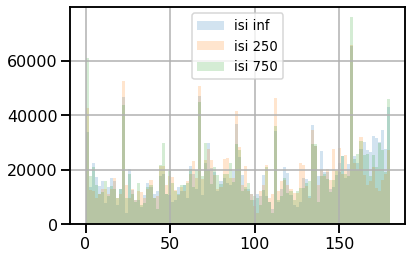

In [396]:
nbin = 100
df_tidy['ori_pref_noad'].hist(alpha=0.2, label='isi inf', bins=nbin)
df_tidy['ori_pref_ad_250'].hist(alpha=0.2, label='isi 250', bins=nbin)
df_tidy['ori_pref_ad_750'].hist(alpha=0.2, label='isi 750', bins=nbin)
plt.legend();

In [398]:
df_control = df_tidy.copy()

df_control['pref_unadapted_distance'] = df_control['ori_pref_noad1'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

df_control.loc['pref_adapted_distance'] = df_control['ori_pref_noad2'].apply(lambda x: distance_from_adapter(x))
df_control['tuning_bias'] = df_control['pref_adapted_distance'] - df_control['pref_unadapted_distance']

# df_control['tuning_bias'] = df_control['ori_pref_noad2'] - df_control['ori_pref_noad1']

df_control.sample(5, random_state=0)

C:\Users\ll357\AppData\Local\Temp\5\ipykernel_43116\2493643551.py:6: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_control.loc['pref_adapted_distance'] = df_control['ori_pref_noad2'].apply(lambda x: distance_from_adapter(x))


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,...,ori_pref_ad_250,ori_pref_noad1,ori_pref_noad2,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,tuning_bias,pref_adapted_distance
427815,0.047,210120_003_54,193.000,R1,750.000,1.000,1.000,0.000,V1,1.000,...,159.682,39.440,164.358,1337,210120,003,39.440,45.000,-32.819,6.621
721733,0.454,201217_002_31,54.000,R2,750.000,1.000,0.000,0.000,LM,0.000,...,141.961,30.600,33.470,1329,201217,002,30.600,45.000,-17.678,12.923
1571067,0.069,230302_004_64,298.000,R2,250.000,1.000,6.000,0.000,LM,1.000,...,54.522,45.258,55.517,1373,230302,004,45.258,45.000,9.263,54.522
537328,-0.192,200804_003_19,306.000,R1,250.000,1.000,4.000,0.000,LM,1.000,...,89.630,96.799,146.369,1322,200804,003,83.201,90.000,6.429,89.630
212258,-0.008,200803_002_58,122.000,R2,6000.000,0.000,4.000,0.000,V1,1.000,...,168.081,166.952,162.034,1322,200803,002,13.048,0.000,NaN,NaN


## tuning bias plot

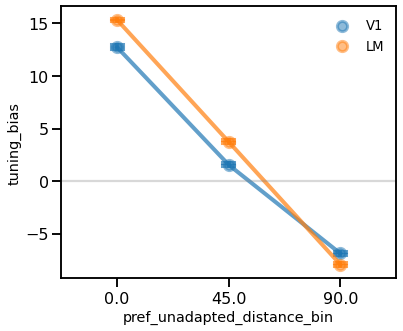

In [401]:
# df_control

df_filter = df_control[(df_control.trial_id > -1) # placeholder, always true
                    & (df_control.filter_cell_vis == True)
                  #   & (df_control.filter_cell_stim == True)
                    # & (df_control.filter_cell_well_fit == True)
                    & (df_control.isi == 250)
                    ]

fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                  #  dodge=True, markers='.', 
                   errorbar=('ci', 95), errwidthfloat=1, capsize=.1,
                #    linestyles=["-", "--", "dashdot"], 
                   )
plt.setp(ax.collections, alpha=.5);
plt.setp(ax.lines, alpha=.7);
plt.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.legend(frameon=False);

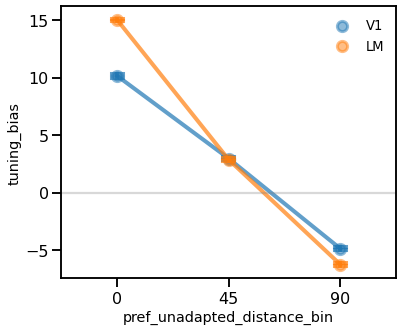

In [402]:
df_filter = df_tidy[(df_tidy.trial_id > -1) # placeholder, always true
                    & (df_tidy.filter_cell_vis == True)
                  #   & (df_tidy.filter_cell_stim == True)
                    # & (df_tidy.filter_cell_well_fit == True)
                    & (df_tidy.isi == 250)
                    ]

fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                  #  dodge=True, markers='.', 
                   errorbar=('ci', 95), errwidthfloat=1, capsize=.1,
                #    linestyles=["-", "--", "dashdot"], 
                   )
plt.setp(ax.collections, alpha=.5);
plt.setp(ax.lines, alpha=.7);
plt.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.legend(frameon=False);

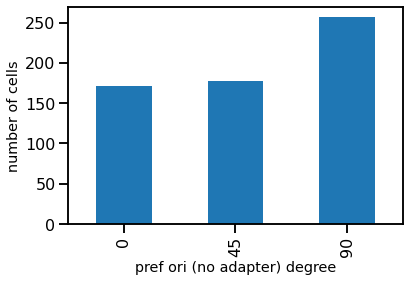

In [200]:
df_filter.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().plot(kind='bar')
# plt.xticks(np.arange(0, 5, 1), np.arange(0, 90+22.5, 22.5), rotation=45)
plt.xlabel('pref ori (no adapter) degree')
plt.ylabel('number of cells');

## adaptation by area

(-0.39034992246499906,
 -0.5270397304841589,
 -0.36549156232592395,
 -0.5153088846528366)

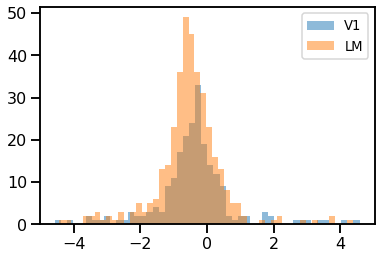

In [207]:
def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 5]

    return gb_adp

df_filter = df_filter[df_filter.isi == 250]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])

plt.hist(gb_adp_V1, bins=50, alpha=.5, label='V1')
plt.hist(gb_adp_LM, bins=50, alpha=.5, label='LM')
plt.legend();
np.mean(gb_adp_V1), np.mean(gb_adp_LM), \
    np.median(gb_adp_V1), np.median(gb_adp_LM)

## polar plot of tuning
before and after adaptation

In [391]:
df_tidy.columns

Index(['dfof', 'cell_id', 'trial_id', 'resp_id', 'isi', 'stim1_contrast',
       'stim2_id', 'stim1_id', 'area', 'filter_cell_vis',
       'filter_cell_well_fit', 'filter_cell_stim', 'ori_pref_noad',
       'ori_pref_ad_750', 'ori_pref_ad_250', 'ori_pref_noad1',
       'ori_pref_noad2', 'mouse', 'date', 'sess', 'pref_unadapted_distance',
       'pref_unadapted_distance_bin', 'tuning_bias'],
      dtype='object')

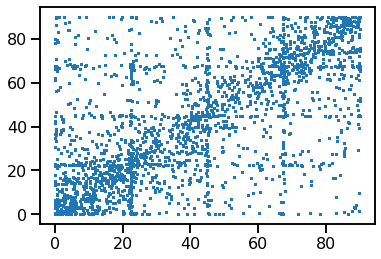

In [394]:
plt.scatter(df_tidy.ori_pref_noad1.apply(lambda x: distance_from_adapter(x)), 
            df_tidy.ori_pref_noad2.apply(lambda x: distance_from_adapter(x)), alpha=.5, s=0.5)

In [253]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 'filter_cell_well_fit', 
                    'ori_pref_ad_250', 'ori_pref_noad']]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & (df_tuning.filter_cell_well_fit == True)
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]

In [262]:
# icell = df_tuning.cell_id.unique()[0]

# tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).sum()['dfof'].values#.tolist() # groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
# df_tuning['tuning_noad'] = np.pi
# df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)

# df_tuning[(df_tuning.cell_id == icell)]

,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,ori_pref_ad_250,ori_pref_noad,tuning_noad
1,0.050,200720_003_0,R1,250,2,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."
2,-0.010,200720_003_0,R1,250,2,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."
5,0.123,200720_003_0,R1,250,7,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."
7,-0.014,200720_003_0,R1,250,4,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."
8,-0.089,200720_003_0,R1,250,5,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."
...,...,...,...,...,...,...,...,...,...,...,...
33516,0.188,200720_003_0,R2,250,3,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."
33517,-0.005,200720_003_0,R2,250,3,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."
33519,-0.020,200720_003_0,R2,6000,6,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."
33523,0.004,200720_003_0,R2,250,1,V1,True,1.000,68.248,82.347,"[0.4614758159764062, 0.3252147048573769, 0.425..."


In [269]:
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).sum()['dfof'].values# groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).sum()['dfof'].values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)
    
df_tuning.sample(5, random_state=0)

100%|██████████| 605/605 [01:20<00:00,  7.51it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,ori_pref_ad_250,ori_pref_noad,tuning_noad,tuning_250
436093,0.060,210120_003_12,R2,250,6,V1,True,1.000,95.956,15.127,"[2.10244417628141, 3.8243843906527006, 0.49117...","[1.2005629456257043, 1.8085154545034658, -0.44..."
199766,0.484,200803_002_31,R2,6000,0,V1,True,1.000,161.591,159.417,"[3.154029525053902, 1.6704793439845753, 0.0545...","[2.9731050129420136, 1.3074845411770695, -0.10..."
1455314,-0.016,230302_003_70,R2,250,5,LM,True,1.000,158.175,165.076,"[2.3907355300060336, 2.426636195146685, 1.2282...","[2.1629949443254306, 1.1136660851624973, 1.774..."
235906,0.015,201015_004_17,R1,250,4,V1,True,1.000,67.754,70.440,"[0.5964879136164359, 0.36374392195000177, 0.35...","[-0.2609437859214771, -0.026907667414503206, 0..."
674006,0.061,201217_002_4,R1,250,0,LM,True,1.000,136.168,131.963,"[-0.22827937648273583, 0.5599172230149758, -0....","[-0.7533841971738179, -1.1431107642475946, -0...."


In [349]:
df_tuning['pref_unadapted_distance'] = df_tuning['ori_pref_noad'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

df_tuning['pref_adapted_distance'] = df_tuning['ori_pref_ad_250'].apply(lambda x: distance_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi

df_tuning['tuning_bias_distance'] = df_tuning['pref_adapted_distance'] - df_tuning['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

df_tuning['tuning_bias_direct'] = df_tuning['ori_pref_ad_250'] - df_tuning['ori_pref_noad']

df_tuning.sample(5, random_state=0)

,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,ori_pref_ad_250,ori_pref_noad,tuning_noad,tuning_250,pref_unadapted_distance,pref_adapted_distance,tuning_bias_distance,tuning_bias_direct
436093,0.060,210120_003_12,R2,250,6,V1,True,1.000,95.956,15.127,"[2.10244417628141, 3.8243843906527006, 0.49117...","[1.2005629456257043, 1.8085154545034658, -0.44...",15.127,84.044,68.917,80.830
199766,0.484,200803_002_31,R2,6000,0,V1,True,1.000,161.591,159.417,"[3.154029525053902, 1.6704793439845753, 0.0545...","[2.9731050129420136, 1.3074845411770695, -0.10...",20.583,18.409,-2.174,2.174
1455314,-0.016,230302_003_70,R2,250,5,LM,True,1.000,158.175,165.076,"[2.3907355300060336, 2.426636195146685, 1.2282...","[2.1629949443254306, 1.1136660851624973, 1.774...",14.924,21.825,6.900,-6.900
235906,0.015,201015_004_17,R1,250,4,V1,True,1.000,67.754,70.440,"[0.5964879136164359, 0.36374392195000177, 0.35...","[-0.2609437859214771, -0.026907667414503206, 0...",70.440,67.754,-2.687,-2.687
674006,0.061,201217_002_4,R1,250,0,LM,True,1.000,136.168,131.963,"[-0.22827937648273583, 0.5599172230149758, -0....","[-0.7533841971738179, -1.1431107642475946, -0....",48.037,43.832,-4.205,4.205


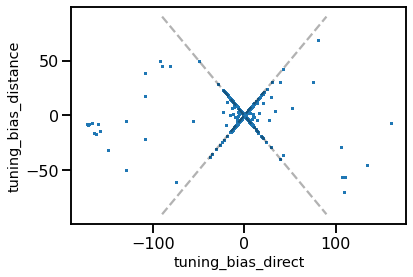

In [386]:
plt.scatter(df_tuning['tuning_bias_direct'], df_tuning['tuning_bias_distance'], s=0.5, alpha=.2,)
plt.xlabel('tuning_bias_direct')
plt.ylabel('tuning_bias_distance')

val = 90
plt.plot([-val, val], [-val, val], 'k--', alpha=.3)

# opposite diagonal
plt.plot([-val, val], [val, -val], 'k--', alpha=.3);

In [367]:
# df_tuning sort by tuning_bias_distance
df_tuning.sort_values(by=['tuning_bias_distance'], inplace=True)

  0%|          | 0/605 [00:00<?, ?it/s]

ori_pref_noad deg:  148.8
ori_pref_ad_250 deg:  0.0
tuning_bias_direct:  -148.8
tuning_bias_distance:  -31.2


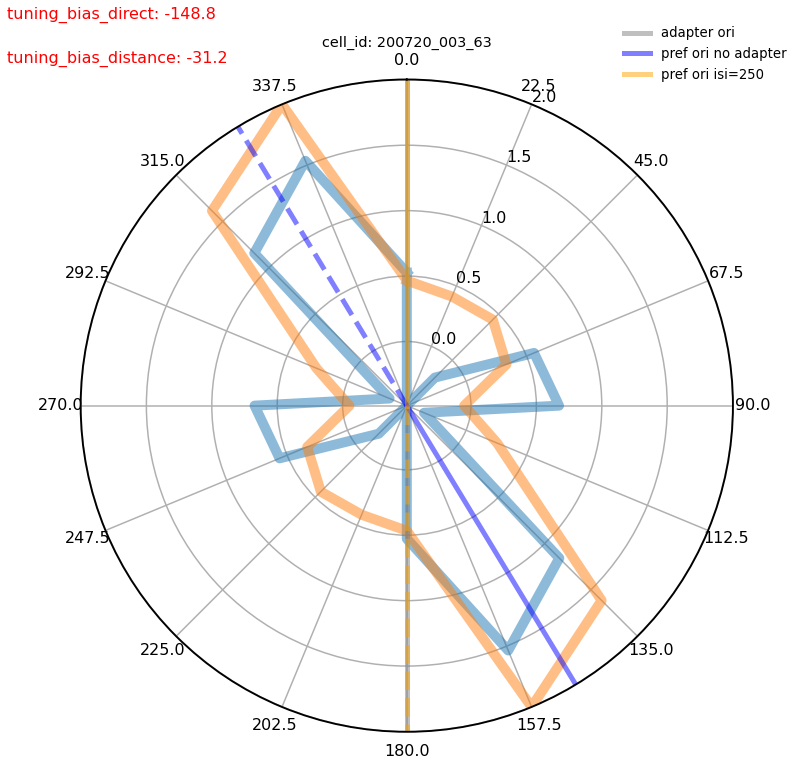

In [389]:
## polar plot of tuning curve

# icell = df_tuning.cell_id.unique()[0]
for icell in tqdm(df_tuning.cell_id.unique()):

    icell = '200720_003_63'

    tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
    tuning_noad = np.append(tuning_noad, tuning_noad) # repeat 8 values twice to make 16 values for polar plot
    tuning_noad = np.append(tuning_noad, tuning_noad[0]) # repeat first value at the end to close the circle
    ori_pref_noad = df_tuning[df_tuning.cell_id == icell].ori_pref_noad.values[0]
    print('ori_pref_noad deg: ', np.round(ori_pref_noad, 2))
    ori_pref_noad = ori_pref_noad * np.pi / 180 # degree to radian

    tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
    tuning_250 = np.append(tuning_250, tuning_250)
    tuning_250 = np.append(tuning_250, tuning_250[0])
    ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].ori_pref_ad_250.values[0]
    print('ori_pref_ad_250 deg: ', np.round(ori_pref_ad_250, 2))
    ori_pref_ad_250 = ori_pref_ad_250 * np.pi / 180

    tuning_bias_direct = df_tuning[df_tuning.cell_id == icell].tuning_bias_direct.values[0]
    tuning_bias_distance = df_tuning[df_tuning.cell_id == icell].tuning_bias_distance.values[0]

    # print('no adapter: ', np.round(tuning_noad, 2))
    # print('250 ms: ', np.round(tuning_250, 2))
    print('tuning_bias_direct: ', np.round(tuning_bias_direct, 2))
    print('tuning_bias_distance: ', np.round(tuning_bias_distance, 2))

    fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection='polar'))
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_noad, alpha=.5, linewidth=10)
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_250, alpha=.5, linewidth=10)
    min_val = np.min([np.min(tuning_noad), np.min(tuning_250)])
    max_val = np.max([np.max(tuning_noad), np.max(tuning_250)])

    ax.plot([0, np.pi], [max_val, max_val], color='gray', linewidth=5, alpha=.5, label='adapter ori')
    ax.plot([ori_pref_noad, ori_pref_noad], [min_val, max_val], color='blue', linewidth=5, alpha=.5, label='pref ori no adapter')
    # find opposite orientation of pref ori
    ori_pref_noad_opp = ori_pref_noad + np.pi
    if ori_pref_noad_opp > 2*np.pi:
        ori_pref_noad_opp = ori_pref_noad_opp - 2*np.pi
    ax.plot([ori_pref_noad_opp, ori_pref_noad_opp], [min_val, max_val], color='blue', linewidth=5, alpha=.5, linestyle='--')
    ax.plot([ori_pref_ad_250, ori_pref_ad_250], [min_val, max_val], color='orange', linewidth=5, alpha=.5, label='pref ori isi=250')
    ori_pref_ad_250_opp = ori_pref_ad_250 + np.pi
    if ori_pref_ad_250_opp > 2*np.pi:
        ori_pref_ad_250_opp = ori_pref_ad_250_opp - 2*np.pi
    ax.plot([ori_pref_ad_250_opp, ori_pref_ad_250_opp], [min_val, max_val], color='orange', linewidth=5, alpha=.5, linestyle='--')

    # add text at top left
    color = 'blue'
    if tuning_bias_direct < 0: # attractive bias
        color = 'red'    
    plt.text(0.05, 0.95, f'tuning_bias_direct: {np.round(tuning_bias_direct, 2)}', transform=plt.gcf().transFigure, color=color, fontsize=16) # in cartesian coordinates
    color = 'blue'
    if tuning_bias_distance < 0: # attractive bias
        color = 'red'
    plt.text(0.05, 0.9, f'tuning_bias_distance: {np.round(tuning_bias_distance, 2)}', transform=plt.gcf().transFigure, color=color, fontsize=16) # in cartesian coordinates

    rticks = np.arange(0, max_val, step=0.5)
    ax.set_rticks(rticks)  # fewer radial ticks

    ax.set_xticks(np.linspace(0, 2*np.pi, 17))
    ax.set_xticklabels(np.arange(0, 360+22.5, 22.5))
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    xticklabels[-1] = '' # set final xticklabel invisible
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(min_val, max_val)

    ax.set_title('cell_id: {}'.format(icell))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False); # set legend position out of the way

    break

    # save figure
    dir_result = r'C:\Users\ll357\Documents\inter\results\tuning bias single cell'.replace('\\', '/')
    # fig.savefig(os.path.join(dir_result, f'tuning_bias_distance_{np.round(tuning_bias_distance, 2)}_tuning_curves.png'), bbox_inches='tight', dpi=300)
    # plt.close(fig)
    # clear_output(wait=True)